# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch Normalization as a tool to more efficiently optimize deep networks.
  

In [1]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from dl4cv.classifiers.fc_net import *
from dl4cv.data_utils import get_CIFAR10_data
from dl4cv.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from dl4cv.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

X_train:  (48000, 3, 32, 32)
y_train:  (48000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Affine layer: foward
Open the file `dl4cv/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [3]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.76984772881e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [4]:
# Test the affine_backward function

x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  1.30762402633e-10
dw error:  7.50459606164e-11
db error:  6.24761544214e-11


# ReLU layer: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [5]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 1e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.99999979802e-08


# ReLU layer: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [6]:
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 1e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.27561113022e-12


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `dl4cv/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [7]:
from dl4cv.layer_utils import affine_relu_forward, affine_relu_backward

x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward:
dx error:  1.06074030813e-10
dw error:  4.3329820388e-10
db error:  2.54800835941e-11


# Loss layers: Softmax
You implemented this loss function in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `dl4cv/layers.py`.

You can make sure that the implementations are correct by running the following:

In [8]:
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))


Testing softmax_loss:
loss:  2.30233767045
dx error:  8.46906529802e-09


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `dl4cv/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [9]:
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-2
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss
Running numeric gradient check with reg =  0.0
W1 relative error: 1.22e-08
W2 relative error: 3.48e-10
b1 relative error: 6.55e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 8.18e-07
W2 relative error: 2.85e-08
b1 relative error: 1.09e-09
b2 relative error: 9.09e-10


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `dl4cv/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [10]:
model = TwoLayerNet(hidden_dim=150, reg=1e-3, weight_scale=1e-3)
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
solver = Solver(model, data,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    lr_decay=0.95,
                    num_epochs=10, batch_size=100,
                    print_every=100)
solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4800) loss: 2.310851
(Epoch 0 / 10) train acc: 0.119000; val_acc: 0.120000
(Iteration 101 / 4800) loss: 1.820342
(Iteration 201 / 4800) loss: 1.644763
(Iteration 301 / 4800) loss: 1.651526
(Iteration 401 / 4800) loss: 1.429098
(Epoch 1 / 10) train acc: 0.456000; val_acc: 0.453000
(Iteration 501 / 4800) loss: 1.541654
(Iteration 601 / 4800) loss: 1.496932
(Iteration 701 / 4800) loss: 1.407564
(Iteration 801 / 4800) loss: 1.724062
(Iteration 901 / 4800) loss: 1.455855
(Epoch 2 / 10) train acc: 0.481000; val_acc: 0.438000
(Iteration 1001 / 4800) loss: 1.553261
(Iteration 1101 / 4800) loss: 1.386981
(Iteration 1201 / 4800) loss: 1.359430
(Iteration 1301 / 4800) loss: 1.463339
(Iteration 1401 / 4800) loss: 1.371866
(Epoch 3 / 10) train acc: 0.507000; val_acc: 0.457000
(Iteration 1501 / 4800) loss: 1.404881
(Iteration 1601 / 4800) loss: 1.213531
(Iteration 1701 / 4800) loss: 1.296094
(Iteration 1801 / 4800) loss: 1.494175
(Iteration 1901 / 4800) loss: 1.283830
(Epoch 4 / 10) t

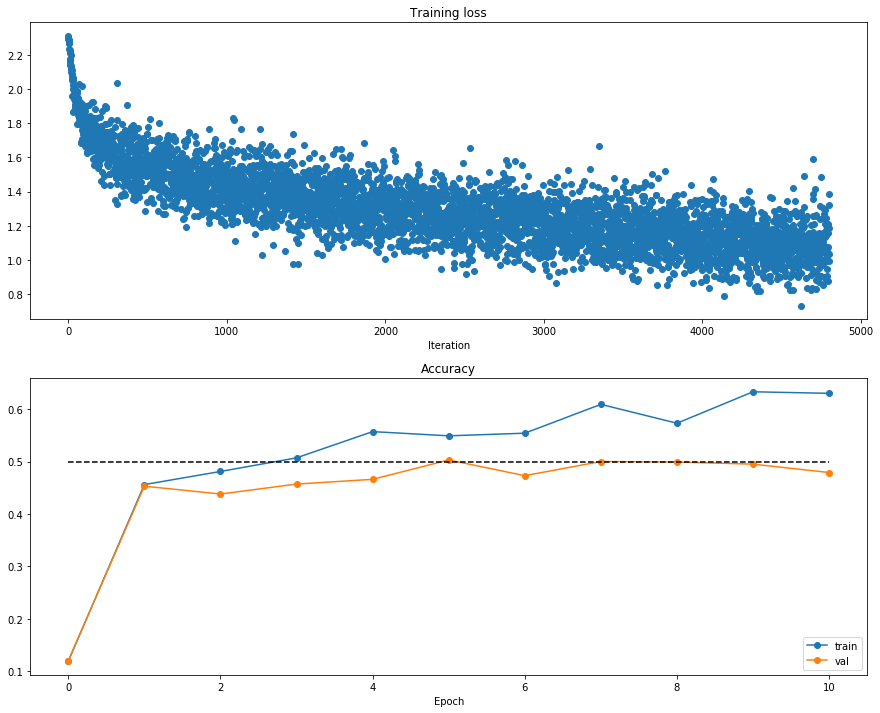

In [11]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `dl4cv/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing batch normalization.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-6 or less.

In [12]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.30300150701
W1 relative error: 1.06e-06
W2 relative error: 3.19e-07
W3 relative error: 1.73e-07
b1 relative error: 7.42e-09
b2 relative error: 1.33e-08
b3 relative error: 1.04e-10
Running check with reg =  3.14
Initial loss:  6.94930736666
W1 relative error: 8.66e-09
W2 relative error: 1.46e-08
W3 relative error: 7.84e-08
b1 relative error: 1.78e-07
b2 relative error: 1.74e-08
b3 relative error: 3.79e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% **training** accuracy within 20 epochs.

(Iteration 1 / 40) loss: 2.268664
(Epoch 0 / 20) train acc: 0.300000; val_acc: 0.113000
(Epoch 1 / 20) train acc: 0.360000; val_acc: 0.134000
(Epoch 2 / 20) train acc: 0.340000; val_acc: 0.104000
(Epoch 3 / 20) train acc: 0.320000; val_acc: 0.127000
(Epoch 4 / 20) train acc: 0.660000; val_acc: 0.168000
(Epoch 5 / 20) train acc: 0.540000; val_acc: 0.166000
(Iteration 11 / 40) loss: 1.172405
(Epoch 6 / 20) train acc: 0.720000; val_acc: 0.155000
(Epoch 7 / 20) train acc: 0.800000; val_acc: 0.143000
(Epoch 8 / 20) train acc: 0.380000; val_acc: 0.152000
(Epoch 9 / 20) train acc: 0.340000; val_acc: 0.097000
(Epoch 10 / 20) train acc: 0.660000; val_acc: 0.137000
(Iteration 21 / 40) loss: 1.472153
(Epoch 11 / 20) train acc: 0.660000; val_acc: 0.153000
(Epoch 12 / 20) train acc: 0.900000; val_acc: 0.165000
(Epoch 13 / 20) train acc: 0.880000; val_acc: 0.156000
(Epoch 14 / 20) train acc: 0.780000; val_acc: 0.154000
(Epoch 15 / 20) train acc: 0.940000; val_acc: 0.146000
(Iteration 31 / 40) loss: 

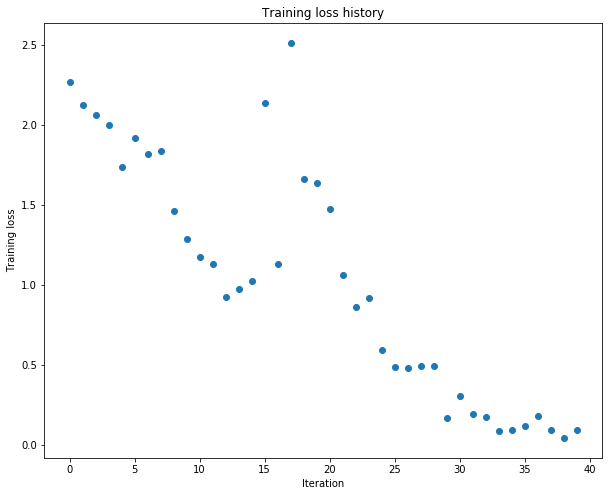

In [13]:
# TODO: Use a three-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-2
learning_rate = 1e-2
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 184.779270
(Epoch 0 / 20) train acc: 0.200000; val_acc: 0.137000
(Epoch 1 / 20) train acc: 0.180000; val_acc: 0.137000
(Epoch 2 / 20) train acc: 0.420000; val_acc: 0.136000
(Epoch 3 / 20) train acc: 0.660000; val_acc: 0.152000
(Epoch 4 / 20) train acc: 0.700000; val_acc: 0.139000
(Epoch 5 / 20) train acc: 0.800000; val_acc: 0.138000
(Iteration 11 / 40) loss: 3.330180
(Epoch 6 / 20) train acc: 0.860000; val_acc: 0.137000
(Epoch 7 / 20) train acc: 0.940000; val_acc: 0.137000
(Epoch 8 / 20) train acc: 0.960000; val_acc: 0.137000
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.144000
(Epoch 10 / 20) train acc: 0.960000; val_acc: 0.141000
(Iteration 21 / 40) loss: 0.000710
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.141000
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.144000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.143000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.143000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.142000
(Iteration 31 / 40) loss

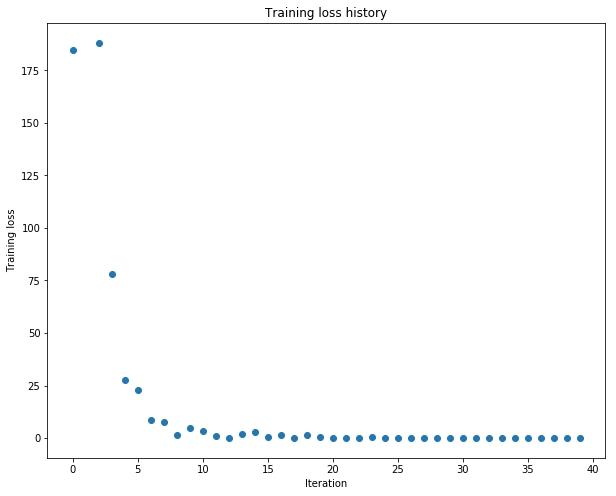

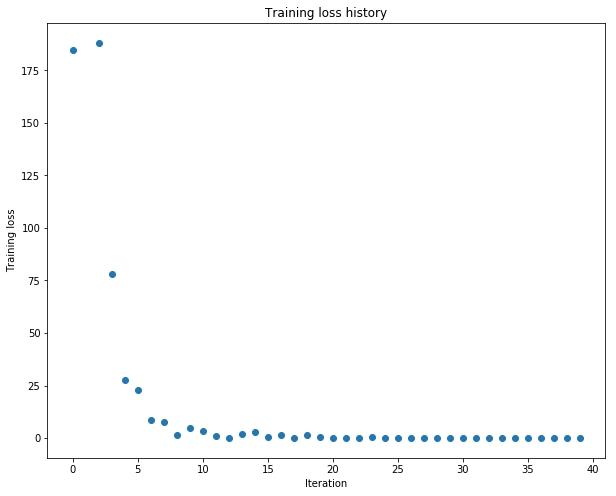

In [14]:
# TODO: Use a five-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

weight_scale = 1e-1
learning_rate = 1e-3
model = FullyConnectedNet([100, 100,100,100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()



# implement your training code here

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net?</p>
    <p>**Your answer:**</p>
</div>


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

Open the file `dl4cv/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-8.

In [15]:
from dl4cv.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.88234703351e-09
velocity error:  4.26928774328e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
(Iteration 1 / 400) loss: 2.303310
(Epoch 0 / 10) train acc: 0.097000; val_acc: 0.090000
(Iteration 11 / 400) loss: 2.299838
(Iteration 21 / 400) loss: 2.297019
(Iteration 31 / 400) loss: 2.293183
(Epoch 1 / 10) train acc: 0.113000; val_acc: 0.142000
(Iteration 41 / 400) loss: 2.302111
(Iteration 51 / 400) loss: 2.290876
(Iteration 61 / 400) loss: 2.291549
(Iteration 71 / 400) loss: 2.284154
(Epoch 2 / 10) train acc: 0.191000; val_acc: 0.177000
(Iteration 81 / 400) loss: 2.284683
(Iteration 91 / 400) loss: 2.274734
(Iteration 101 / 400) loss: 2.277961
(Iteration 111 / 400) loss: 2.263787
(Epoch 3 / 10) train acc: 0.211000; val_acc: 0.184000
(Iteration 121 / 400) loss: 2.268469
(Iteration 131 / 400) loss: 2.213101
(Iteration 141 / 400) loss: 2.217266
(Iteration 151 / 400) loss: 2.204256
(Epoch 4 / 10) train acc: 0.241000; val_acc: 0.209000
(Iteration 161 / 400) loss: 2.145519
(Iteration 171 / 400) loss: 2.135860
(Iteration 181 / 400) loss: 2.077155
(Iteration 191 / 400

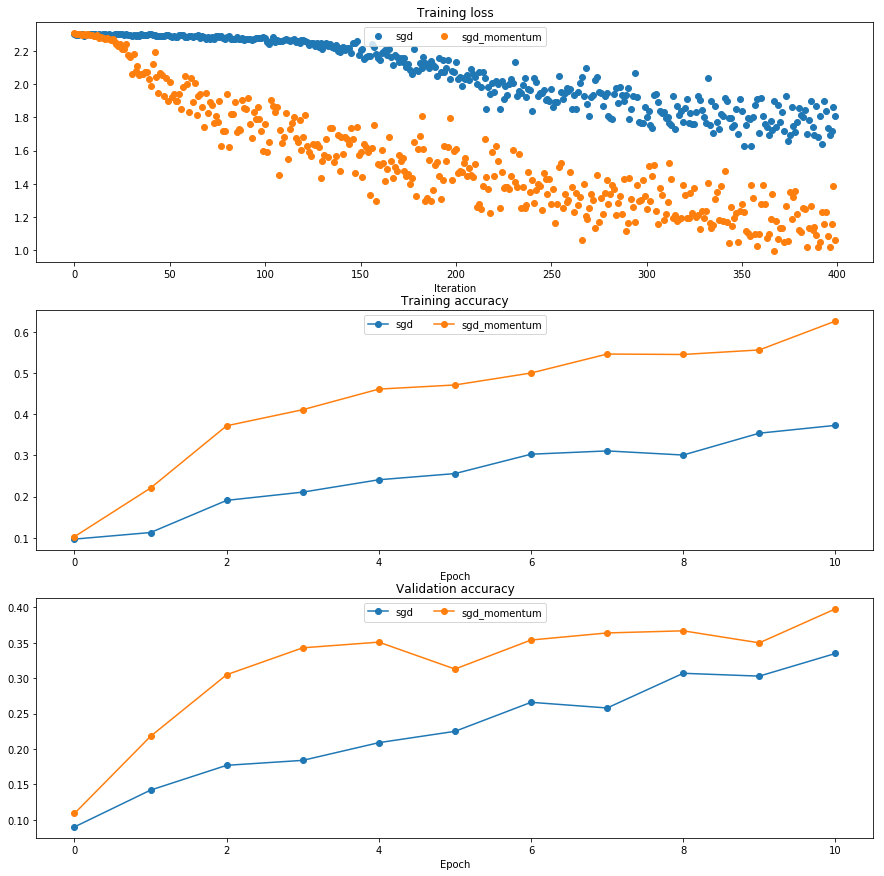

In [16]:
num_train = 4000
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=3e-2)

    solver = Solver(model, small_data,
                    num_epochs=10, batch_size=100,
                    update_rule=update_rule,
                    optim_config={'learning_rate': 1e-2},
                    verbose=True)
    solvers[update_rule] = solver
    solver.train()
    print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)
  
    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Adam
Adam [1] is an update rule that sets per-parameter learning rates by using a running average of the second moments of gradients.

In the file `dl4cv/optim.py`, we have implemented the update rule `adam` for you. Check this implementation and make sure you understand what the optimizer is doing. Then train the fully connected net below to see how Adam affects the learning process.

[1] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

running with  adam
(Iteration 1 / 400) loss: 3.183189
(Epoch 0 / 10) train acc: 0.124000; val_acc: 0.126000
(Iteration 11 / 400) loss: 2.034526
(Iteration 21 / 400) loss: 1.992983
(Iteration 31 / 400) loss: 1.763884
(Epoch 1 / 10) train acc: 0.359000; val_acc: 0.302000
(Iteration 41 / 400) loss: 1.746197
(Iteration 51 / 400) loss: 1.623868
(Iteration 61 / 400) loss: 1.583242
(Iteration 71 / 400) loss: 1.745927
(Epoch 2 / 10) train acc: 0.436000; val_acc: 0.324000
(Iteration 81 / 400) loss: 1.736030
(Iteration 91 / 400) loss: 1.810499
(Iteration 101 / 400) loss: 1.561074
(Iteration 111 / 400) loss: 1.630231
(Epoch 3 / 10) train acc: 0.457000; val_acc: 0.346000
(Iteration 121 / 400) loss: 1.370163
(Iteration 131 / 400) loss: 1.458881
(Iteration 141 / 400) loss: 1.531772
(Iteration 151 / 400) loss: 1.326657
(Epoch 4 / 10) train acc: 0.536000; val_acc: 0.347000
(Iteration 161 / 400) loss: 1.359145
(Iteration 171 / 400) loss: 1.477542
(Iteration 181 / 400) loss: 1.420749
(Iteration 191 / 40

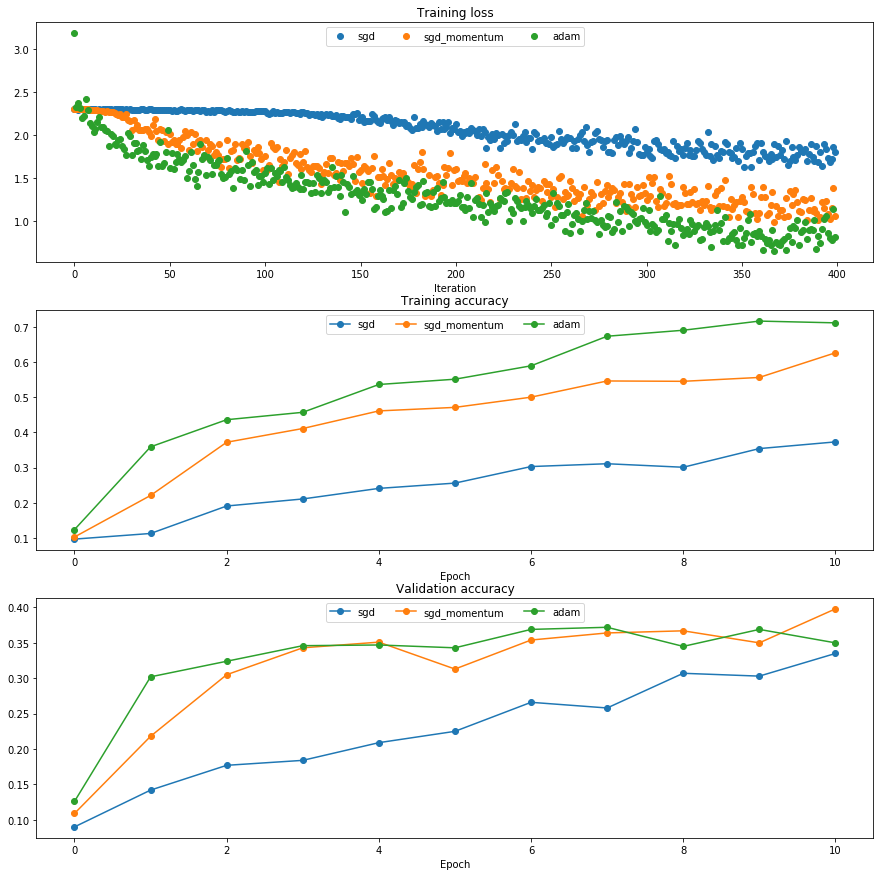

In [17]:
learning_rates = {'adam': 1e-3}
update_rule = 'adam'
print('running with ', update_rule)
model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

solver = Solver(model, small_data,
              num_epochs=10, batch_size=100,
              update_rule=update_rule,
              optim_config={
                'learning_rate': learning_rates[update_rule]
              },
              verbose=True)
solvers[update_rule] = solver
solver.train()
print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)
  
    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
    
plt.gcf().set_size_inches(15, 15)
plt.show()

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 48% accuracy on the validation set using a fully-connected net.

You might find it useful to complete the `2_BatchNormalization.ipynb` notebook before completing this part, since this technique can help you train powerful models.

In [42]:
best_model = None

################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
# Note that dropout is not required to pass beyond the linear scoring regime   #
################################################################################
learning_rates = 1e-3
update_rule = 'adam' #'sgd_momentum'
model = FullyConnectedNet([100, 50, 100, 100, 50, 100, 100, 50, 100, 100, 50, 100], dropout=0.2, use_batchnorm=True, weight_scale=1e-2)

solver = Solver(model, data,
              num_epochs=150, batch_size=100,
              update_rule=update_rule,
              optim_config={
                'learning_rate': learning_rates
              },
              verbose=True)
solver.train()
best_model=model
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 72000) loss: 2.305012
(Epoch 0 / 150) train acc: 0.070000; val_acc: 0.098000
(Iteration 11 / 72000) loss: 2.313166
(Iteration 21 / 72000) loss: 2.279065
(Iteration 31 / 72000) loss: 2.294908
(Iteration 41 / 72000) loss: 2.246198
(Iteration 51 / 72000) loss: 2.151266
(Iteration 61 / 72000) loss: 2.254403
(Iteration 71 / 72000) loss: 2.191986
(Iteration 81 / 72000) loss: 2.145935
(Iteration 91 / 72000) loss: 2.052089
(Iteration 101 / 72000) loss: 2.035398
(Iteration 111 / 72000) loss: 1.969731
(Iteration 121 / 72000) loss: 2.038975
(Iteration 131 / 72000) loss: 1.981129
(Iteration 141 / 72000) loss: 1.999953
(Iteration 151 / 72000) loss: 2.134810
(Iteration 161 / 72000) loss: 1.977245
(Iteration 171 / 72000) loss: 1.945232
(Iteration 181 / 72000) loss: 1.932042
(Iteration 191 / 72000) loss: 1.949369
(Iteration 201 / 72000) loss: 1.878278
(Iteration 211 / 72000) loss: 1.858516
(Iteration 221 / 72000) loss: 1.986272
(Iteration 231 / 72000) loss: 2.151718
(Iteration 241 / 720

(Iteration 2011 / 72000) loss: 1.960146
(Iteration 2021 / 72000) loss: 1.754220
(Iteration 2031 / 72000) loss: 1.861115
(Iteration 2041 / 72000) loss: 1.857430
(Iteration 2051 / 72000) loss: 1.746287
(Iteration 2061 / 72000) loss: 1.771782
(Iteration 2071 / 72000) loss: 1.695851
(Iteration 2081 / 72000) loss: 1.737050
(Iteration 2091 / 72000) loss: 1.637607
(Iteration 2101 / 72000) loss: 1.716425
(Iteration 2111 / 72000) loss: 1.660844
(Iteration 2121 / 72000) loss: 1.503988
(Iteration 2131 / 72000) loss: 1.794848
(Iteration 2141 / 72000) loss: 1.593861
(Iteration 2151 / 72000) loss: 1.660001
(Iteration 2161 / 72000) loss: 1.637608
(Iteration 2171 / 72000) loss: 1.840223
(Iteration 2181 / 72000) loss: 1.899427
(Iteration 2191 / 72000) loss: 1.625281
(Iteration 2201 / 72000) loss: 1.817408
(Iteration 2211 / 72000) loss: 1.763738
(Iteration 2221 / 72000) loss: 1.703360
(Iteration 2231 / 72000) loss: 1.720349
(Iteration 2241 / 72000) loss: 1.643244
(Iteration 2251 / 72000) loss: 1.756315


(Iteration 4021 / 72000) loss: 1.715858
(Iteration 4031 / 72000) loss: 1.727847
(Iteration 4041 / 72000) loss: 1.617843
(Iteration 4051 / 72000) loss: 1.557216
(Iteration 4061 / 72000) loss: 1.515242
(Iteration 4071 / 72000) loss: 1.625406
(Iteration 4081 / 72000) loss: 1.400200
(Iteration 4091 / 72000) loss: 1.643660
(Iteration 4101 / 72000) loss: 1.863124
(Iteration 4111 / 72000) loss: 1.615926
(Iteration 4121 / 72000) loss: 1.860774
(Iteration 4131 / 72000) loss: 1.687053
(Iteration 4141 / 72000) loss: 1.686855
(Iteration 4151 / 72000) loss: 1.543733
(Iteration 4161 / 72000) loss: 1.795994
(Iteration 4171 / 72000) loss: 1.784436
(Iteration 4181 / 72000) loss: 1.877105
(Iteration 4191 / 72000) loss: 1.837232
(Iteration 4201 / 72000) loss: 1.581751
(Iteration 4211 / 72000) loss: 1.603885
(Iteration 4221 / 72000) loss: 1.666705
(Iteration 4231 / 72000) loss: 1.630978
(Iteration 4241 / 72000) loss: 1.441559
(Iteration 4251 / 72000) loss: 1.536026
(Iteration 4261 / 72000) loss: 1.703028


(Iteration 6031 / 72000) loss: 1.588410
(Iteration 6041 / 72000) loss: 1.571146
(Iteration 6051 / 72000) loss: 1.503311
(Iteration 6061 / 72000) loss: 1.632301
(Iteration 6071 / 72000) loss: 1.427128
(Iteration 6081 / 72000) loss: 1.662616
(Iteration 6091 / 72000) loss: 1.643578
(Iteration 6101 / 72000) loss: 1.689215
(Iteration 6111 / 72000) loss: 1.468951
(Iteration 6121 / 72000) loss: 1.727053
(Iteration 6131 / 72000) loss: 1.702784
(Iteration 6141 / 72000) loss: 1.621746
(Iteration 6151 / 72000) loss: 1.533869
(Iteration 6161 / 72000) loss: 1.719344
(Iteration 6171 / 72000) loss: 1.489570
(Iteration 6181 / 72000) loss: 1.487220
(Iteration 6191 / 72000) loss: 1.605450
(Iteration 6201 / 72000) loss: 1.451069
(Iteration 6211 / 72000) loss: 1.526768
(Iteration 6221 / 72000) loss: 1.607996
(Iteration 6231 / 72000) loss: 1.580508
(Epoch 13 / 150) train acc: 0.474000; val_acc: 0.460000
(Iteration 6241 / 72000) loss: 1.480989
(Iteration 6251 / 72000) loss: 1.660776
(Iteration 6261 / 72000)

(Iteration 8041 / 72000) loss: 1.587608
(Iteration 8051 / 72000) loss: 1.447199
(Iteration 8061 / 72000) loss: 1.462838
(Iteration 8071 / 72000) loss: 1.472098
(Iteration 8081 / 72000) loss: 1.554813
(Iteration 8091 / 72000) loss: 1.340054
(Iteration 8101 / 72000) loss: 1.505724
(Iteration 8111 / 72000) loss: 1.641923
(Iteration 8121 / 72000) loss: 1.634748
(Iteration 8131 / 72000) loss: 1.664033
(Iteration 8141 / 72000) loss: 1.509651
(Iteration 8151 / 72000) loss: 1.674833
(Epoch 17 / 150) train acc: 0.484000; val_acc: 0.472000
(Iteration 8161 / 72000) loss: 1.610108
(Iteration 8171 / 72000) loss: 1.574654
(Iteration 8181 / 72000) loss: 1.671392
(Iteration 8191 / 72000) loss: 1.696126
(Iteration 8201 / 72000) loss: 1.700782
(Iteration 8211 / 72000) loss: 1.542533
(Iteration 8221 / 72000) loss: 1.559278
(Iteration 8231 / 72000) loss: 1.533463
(Iteration 8241 / 72000) loss: 1.584915
(Iteration 8251 / 72000) loss: 1.455899
(Iteration 8261 / 72000) loss: 1.577115
(Iteration 8271 / 72000)

(Iteration 10041 / 72000) loss: 1.465964
(Iteration 10051 / 72000) loss: 1.289665
(Iteration 10061 / 72000) loss: 1.449011
(Iteration 10071 / 72000) loss: 1.464440
(Epoch 21 / 150) train acc: 0.521000; val_acc: 0.483000
(Iteration 10081 / 72000) loss: 1.689606
(Iteration 10091 / 72000) loss: 1.501202
(Iteration 10101 / 72000) loss: 1.522598
(Iteration 10111 / 72000) loss: 1.342889
(Iteration 10121 / 72000) loss: 1.662683
(Iteration 10131 / 72000) loss: 1.458802
(Iteration 10141 / 72000) loss: 1.439312
(Iteration 10151 / 72000) loss: 1.448428
(Iteration 10161 / 72000) loss: 1.515265
(Iteration 10171 / 72000) loss: 1.477458
(Iteration 10181 / 72000) loss: 1.534821
(Iteration 10191 / 72000) loss: 1.715544
(Iteration 10201 / 72000) loss: 1.700152
(Iteration 10211 / 72000) loss: 1.658745
(Iteration 10221 / 72000) loss: 1.518307
(Iteration 10231 / 72000) loss: 1.415339
(Iteration 10241 / 72000) loss: 1.388094
(Iteration 10251 / 72000) loss: 1.390890
(Iteration 10261 / 72000) loss: 1.558776
(

(Iteration 11991 / 72000) loss: 1.428713
(Epoch 25 / 150) train acc: 0.546000; val_acc: 0.492000
(Iteration 12001 / 72000) loss: 1.440429
(Iteration 12011 / 72000) loss: 1.302820
(Iteration 12021 / 72000) loss: 1.249419
(Iteration 12031 / 72000) loss: 1.384092
(Iteration 12041 / 72000) loss: 1.417035
(Iteration 12051 / 72000) loss: 1.485852
(Iteration 12061 / 72000) loss: 1.495919
(Iteration 12071 / 72000) loss: 1.466783
(Iteration 12081 / 72000) loss: 1.536504
(Iteration 12091 / 72000) loss: 1.659267
(Iteration 12101 / 72000) loss: 1.460140
(Iteration 12111 / 72000) loss: 1.390902
(Iteration 12121 / 72000) loss: 1.388138
(Iteration 12131 / 72000) loss: 1.429990
(Iteration 12141 / 72000) loss: 1.456805
(Iteration 12151 / 72000) loss: 1.351292
(Iteration 12161 / 72000) loss: 1.463765
(Iteration 12171 / 72000) loss: 1.499653
(Iteration 12181 / 72000) loss: 1.470614
(Iteration 12191 / 72000) loss: 1.553484
(Iteration 12201 / 72000) loss: 1.505273
(Iteration 12211 / 72000) loss: 1.659321
(

(Iteration 13931 / 72000) loss: 1.505552
(Iteration 13941 / 72000) loss: 1.462682
(Iteration 13951 / 72000) loss: 1.468880
(Iteration 13961 / 72000) loss: 1.450659
(Iteration 13971 / 72000) loss: 1.373692
(Iteration 13981 / 72000) loss: 1.384844
(Iteration 13991 / 72000) loss: 1.283088
(Iteration 14001 / 72000) loss: 1.396596
(Iteration 14011 / 72000) loss: 1.535848
(Iteration 14021 / 72000) loss: 1.434203
(Iteration 14031 / 72000) loss: 1.569999
(Iteration 14041 / 72000) loss: 1.388934
(Iteration 14051 / 72000) loss: 1.428995
(Iteration 14061 / 72000) loss: 1.407592
(Iteration 14071 / 72000) loss: 1.433193
(Iteration 14081 / 72000) loss: 1.300458
(Iteration 14091 / 72000) loss: 1.444961
(Iteration 14101 / 72000) loss: 1.327554
(Iteration 14111 / 72000) loss: 1.290326
(Iteration 14121 / 72000) loss: 1.364031
(Iteration 14131 / 72000) loss: 1.628283
(Iteration 14141 / 72000) loss: 1.288741
(Iteration 14151 / 72000) loss: 1.482963
(Iteration 14161 / 72000) loss: 1.549667
(Iteration 14171

(Iteration 15881 / 72000) loss: 1.326508
(Iteration 15891 / 72000) loss: 1.521918
(Iteration 15901 / 72000) loss: 1.395620
(Iteration 15911 / 72000) loss: 1.534414
(Iteration 15921 / 72000) loss: 1.555491
(Iteration 15931 / 72000) loss: 1.790336
(Iteration 15941 / 72000) loss: 1.374972
(Iteration 15951 / 72000) loss: 1.447383
(Iteration 15961 / 72000) loss: 1.382318
(Iteration 15971 / 72000) loss: 1.501433
(Iteration 15981 / 72000) loss: 1.455110
(Iteration 15991 / 72000) loss: 1.333750
(Iteration 16001 / 72000) loss: 1.394347
(Iteration 16011 / 72000) loss: 1.500248
(Iteration 16021 / 72000) loss: 1.364882
(Iteration 16031 / 72000) loss: 1.392406
(Iteration 16041 / 72000) loss: 1.609976
(Iteration 16051 / 72000) loss: 1.289645
(Iteration 16061 / 72000) loss: 1.401141
(Iteration 16071 / 72000) loss: 1.243266
(Iteration 16081 / 72000) loss: 1.395151
(Iteration 16091 / 72000) loss: 1.405395
(Iteration 16101 / 72000) loss: 1.426329
(Iteration 16111 / 72000) loss: 1.468064
(Iteration 16121

(Iteration 17831 / 72000) loss: 1.415322
(Iteration 17841 / 72000) loss: 1.344170
(Iteration 17851 / 72000) loss: 1.473276
(Iteration 17861 / 72000) loss: 1.504101
(Iteration 17871 / 72000) loss: 1.226681
(Iteration 17881 / 72000) loss: 1.352166
(Iteration 17891 / 72000) loss: 1.462237
(Iteration 17901 / 72000) loss: 1.607701
(Iteration 17911 / 72000) loss: 1.351465
(Iteration 17921 / 72000) loss: 1.477762
(Iteration 17931 / 72000) loss: 1.398513
(Iteration 17941 / 72000) loss: 1.525365
(Iteration 17951 / 72000) loss: 1.363198
(Iteration 17961 / 72000) loss: 1.408569
(Iteration 17971 / 72000) loss: 1.550175
(Iteration 17981 / 72000) loss: 1.367471
(Iteration 17991 / 72000) loss: 1.376993
(Iteration 18001 / 72000) loss: 1.393124
(Iteration 18011 / 72000) loss: 1.569560
(Iteration 18021 / 72000) loss: 1.357596
(Iteration 18031 / 72000) loss: 1.484094
(Iteration 18041 / 72000) loss: 1.464838
(Iteration 18051 / 72000) loss: 1.495154
(Iteration 18061 / 72000) loss: 1.459223
(Iteration 18071

(Iteration 19781 / 72000) loss: 1.258004
(Iteration 19791 / 72000) loss: 1.297744
(Iteration 19801 / 72000) loss: 1.494906
(Iteration 19811 / 72000) loss: 1.347584
(Iteration 19821 / 72000) loss: 1.278738
(Iteration 19831 / 72000) loss: 1.491864
(Iteration 19841 / 72000) loss: 1.497623
(Iteration 19851 / 72000) loss: 1.545908
(Iteration 19861 / 72000) loss: 1.449018
(Iteration 19871 / 72000) loss: 1.310914
(Iteration 19881 / 72000) loss: 1.296692
(Iteration 19891 / 72000) loss: 1.306498
(Iteration 19901 / 72000) loss: 1.316327
(Iteration 19911 / 72000) loss: 1.445898
(Iteration 19921 / 72000) loss: 1.361294
(Iteration 19931 / 72000) loss: 1.419313
(Iteration 19941 / 72000) loss: 1.292663
(Iteration 19951 / 72000) loss: 1.203320
(Iteration 19961 / 72000) loss: 1.598986
(Iteration 19971 / 72000) loss: 1.223530
(Iteration 19981 / 72000) loss: 1.344057
(Iteration 19991 / 72000) loss: 1.480453
(Iteration 20001 / 72000) loss: 1.624160
(Iteration 20011 / 72000) loss: 1.420306
(Iteration 20021

(Iteration 21741 / 72000) loss: 1.408925
(Iteration 21751 / 72000) loss: 1.288593
(Iteration 21761 / 72000) loss: 1.440584
(Iteration 21771 / 72000) loss: 1.577883
(Iteration 21781 / 72000) loss: 1.564073
(Iteration 21791 / 72000) loss: 1.527104
(Iteration 21801 / 72000) loss: 1.355236
(Iteration 21811 / 72000) loss: 1.537907
(Iteration 21821 / 72000) loss: 1.437662
(Iteration 21831 / 72000) loss: 1.354879
(Iteration 21841 / 72000) loss: 1.528007
(Iteration 21851 / 72000) loss: 1.524007
(Iteration 21861 / 72000) loss: 1.492316
(Iteration 21871 / 72000) loss: 1.623961
(Iteration 21881 / 72000) loss: 1.240405
(Iteration 21891 / 72000) loss: 1.336403
(Iteration 21901 / 72000) loss: 1.496109
(Iteration 21911 / 72000) loss: 1.601734
(Iteration 21921 / 72000) loss: 1.493063
(Iteration 21931 / 72000) loss: 1.286108
(Iteration 21941 / 72000) loss: 1.366734
(Iteration 21951 / 72000) loss: 1.489130
(Iteration 21961 / 72000) loss: 1.520493
(Iteration 21971 / 72000) loss: 1.233558
(Iteration 21981

(Iteration 23691 / 72000) loss: 1.535722
(Iteration 23701 / 72000) loss: 1.367012
(Iteration 23711 / 72000) loss: 1.492195
(Iteration 23721 / 72000) loss: 1.204406
(Iteration 23731 / 72000) loss: 1.372883
(Iteration 23741 / 72000) loss: 1.361146
(Iteration 23751 / 72000) loss: 1.338190
(Iteration 23761 / 72000) loss: 1.509574
(Iteration 23771 / 72000) loss: 1.416769
(Iteration 23781 / 72000) loss: 1.265883
(Iteration 23791 / 72000) loss: 1.377593
(Iteration 23801 / 72000) loss: 1.297332
(Iteration 23811 / 72000) loss: 1.412328
(Iteration 23821 / 72000) loss: 1.377548
(Iteration 23831 / 72000) loss: 1.300248
(Iteration 23841 / 72000) loss: 1.303026
(Iteration 23851 / 72000) loss: 1.287654
(Iteration 23861 / 72000) loss: 1.510064
(Iteration 23871 / 72000) loss: 1.256764
(Iteration 23881 / 72000) loss: 1.413960
(Iteration 23891 / 72000) loss: 1.290495
(Iteration 23901 / 72000) loss: 1.433547
(Iteration 23911 / 72000) loss: 1.408349
(Iteration 23921 / 72000) loss: 1.309233
(Iteration 23931

(Iteration 25651 / 72000) loss: 1.489439
(Iteration 25661 / 72000) loss: 1.454555
(Iteration 25671 / 72000) loss: 1.334176
(Iteration 25681 / 72000) loss: 1.324450
(Iteration 25691 / 72000) loss: 1.320194
(Iteration 25701 / 72000) loss: 1.623470
(Iteration 25711 / 72000) loss: 1.326172
(Iteration 25721 / 72000) loss: 1.296516
(Iteration 25731 / 72000) loss: 1.333205
(Iteration 25741 / 72000) loss: 1.306767
(Iteration 25751 / 72000) loss: 1.189396
(Iteration 25761 / 72000) loss: 1.269336
(Iteration 25771 / 72000) loss: 1.340380
(Iteration 25781 / 72000) loss: 1.396268
(Iteration 25791 / 72000) loss: 1.359136
(Iteration 25801 / 72000) loss: 1.259492
(Iteration 25811 / 72000) loss: 1.419826
(Iteration 25821 / 72000) loss: 1.281182
(Iteration 25831 / 72000) loss: 1.397143
(Iteration 25841 / 72000) loss: 1.338449
(Iteration 25851 / 72000) loss: 1.280508
(Iteration 25861 / 72000) loss: 1.388210
(Iteration 25871 / 72000) loss: 1.277807
(Iteration 25881 / 72000) loss: 1.241175
(Iteration 25891

(Iteration 27601 / 72000) loss: 1.294798
(Iteration 27611 / 72000) loss: 1.379885
(Iteration 27621 / 72000) loss: 1.411011
(Iteration 27631 / 72000) loss: 1.251273
(Iteration 27641 / 72000) loss: 1.307288
(Iteration 27651 / 72000) loss: 1.332508
(Iteration 27661 / 72000) loss: 1.271712
(Iteration 27671 / 72000) loss: 1.201632
(Iteration 27681 / 72000) loss: 1.274765
(Iteration 27691 / 72000) loss: 1.278016
(Iteration 27701 / 72000) loss: 1.237365
(Iteration 27711 / 72000) loss: 1.373261
(Iteration 27721 / 72000) loss: 1.288012
(Iteration 27731 / 72000) loss: 1.322429
(Iteration 27741 / 72000) loss: 1.570471
(Iteration 27751 / 72000) loss: 1.552657
(Iteration 27761 / 72000) loss: 1.372986
(Iteration 27771 / 72000) loss: 1.244117
(Iteration 27781 / 72000) loss: 1.574441
(Iteration 27791 / 72000) loss: 1.444030
(Iteration 27801 / 72000) loss: 1.491768
(Iteration 27811 / 72000) loss: 1.339497
(Iteration 27821 / 72000) loss: 1.419150
(Iteration 27831 / 72000) loss: 1.344200
(Epoch 58 / 150)

(Iteration 29551 / 72000) loss: 1.362142
(Iteration 29561 / 72000) loss: 1.305296
(Iteration 29571 / 72000) loss: 1.262219
(Iteration 29581 / 72000) loss: 1.456910
(Iteration 29591 / 72000) loss: 1.276645
(Iteration 29601 / 72000) loss: 1.346273
(Iteration 29611 / 72000) loss: 1.477787
(Iteration 29621 / 72000) loss: 1.194602
(Iteration 29631 / 72000) loss: 1.356090
(Iteration 29641 / 72000) loss: 1.298020
(Iteration 29651 / 72000) loss: 1.395554
(Iteration 29661 / 72000) loss: 1.270980
(Iteration 29671 / 72000) loss: 1.245488
(Iteration 29681 / 72000) loss: 1.656901
(Iteration 29691 / 72000) loss: 1.422403
(Iteration 29701 / 72000) loss: 1.365460
(Iteration 29711 / 72000) loss: 1.201819
(Iteration 29721 / 72000) loss: 1.278632
(Iteration 29731 / 72000) loss: 1.238432
(Iteration 29741 / 72000) loss: 1.442419
(Iteration 29751 / 72000) loss: 1.246688
(Epoch 62 / 150) train acc: 0.582000; val_acc: 0.502000
(Iteration 29761 / 72000) loss: 1.358742
(Iteration 29771 / 72000) loss: 1.395346
(

(Iteration 31501 / 72000) loss: 1.354515
(Iteration 31511 / 72000) loss: 1.282902
(Iteration 31521 / 72000) loss: 1.173133
(Iteration 31531 / 72000) loss: 1.351798
(Iteration 31541 / 72000) loss: 1.424737
(Iteration 31551 / 72000) loss: 1.149777
(Iteration 31561 / 72000) loss: 1.418181
(Iteration 31571 / 72000) loss: 1.456253
(Iteration 31581 / 72000) loss: 1.290278
(Iteration 31591 / 72000) loss: 1.340093
(Iteration 31601 / 72000) loss: 1.471749
(Iteration 31611 / 72000) loss: 1.275326
(Iteration 31621 / 72000) loss: 1.271381
(Iteration 31631 / 72000) loss: 1.376946
(Iteration 31641 / 72000) loss: 1.335808
(Iteration 31651 / 72000) loss: 1.359366
(Iteration 31661 / 72000) loss: 1.335425
(Iteration 31671 / 72000) loss: 1.399934
(Epoch 66 / 150) train acc: 0.582000; val_acc: 0.525000
(Iteration 31681 / 72000) loss: 1.382451
(Iteration 31691 / 72000) loss: 1.476635
(Iteration 31701 / 72000) loss: 1.426824
(Iteration 31711 / 72000) loss: 1.236603
(Iteration 31721 / 72000) loss: 1.483229
(

(Iteration 33461 / 72000) loss: 1.261338
(Iteration 33471 / 72000) loss: 1.323540
(Iteration 33481 / 72000) loss: 1.236984
(Iteration 33491 / 72000) loss: 1.270089
(Iteration 33501 / 72000) loss: 1.254520
(Iteration 33511 / 72000) loss: 1.209426
(Iteration 33521 / 72000) loss: 1.227449
(Iteration 33531 / 72000) loss: 1.304111
(Iteration 33541 / 72000) loss: 1.242891
(Iteration 33551 / 72000) loss: 1.338556
(Iteration 33561 / 72000) loss: 1.327053
(Iteration 33571 / 72000) loss: 1.227531
(Iteration 33581 / 72000) loss: 1.445716
(Iteration 33591 / 72000) loss: 1.287848
(Epoch 70 / 150) train acc: 0.615000; val_acc: 0.512000
(Iteration 33601 / 72000) loss: 1.382763
(Iteration 33611 / 72000) loss: 1.317337
(Iteration 33621 / 72000) loss: 1.272400
(Iteration 33631 / 72000) loss: 1.228098
(Iteration 33641 / 72000) loss: 1.278477
(Iteration 33651 / 72000) loss: 1.391376
(Iteration 33661 / 72000) loss: 1.351466
(Iteration 33671 / 72000) loss: 1.449932
(Iteration 33681 / 72000) loss: 1.366562
(

(Iteration 35421 / 72000) loss: 1.438691
(Iteration 35431 / 72000) loss: 1.161134
(Iteration 35441 / 72000) loss: 1.378486
(Iteration 35451 / 72000) loss: 1.331655
(Iteration 35461 / 72000) loss: 1.675793
(Iteration 35471 / 72000) loss: 1.283572
(Iteration 35481 / 72000) loss: 1.360876
(Iteration 35491 / 72000) loss: 1.429319
(Iteration 35501 / 72000) loss: 1.198367
(Iteration 35511 / 72000) loss: 1.406581
(Epoch 74 / 150) train acc: 0.620000; val_acc: 0.510000
(Iteration 35521 / 72000) loss: 1.290419
(Iteration 35531 / 72000) loss: 1.289887
(Iteration 35541 / 72000) loss: 1.363060
(Iteration 35551 / 72000) loss: 1.355383
(Iteration 35561 / 72000) loss: 1.278955
(Iteration 35571 / 72000) loss: 1.225100
(Iteration 35581 / 72000) loss: 1.156693
(Iteration 35591 / 72000) loss: 1.395761
(Iteration 35601 / 72000) loss: 1.339861
(Iteration 35611 / 72000) loss: 1.233239
(Iteration 35621 / 72000) loss: 1.425285
(Iteration 35631 / 72000) loss: 1.349965
(Iteration 35641 / 72000) loss: 1.505859
(

(Iteration 37381 / 72000) loss: 1.374111
(Iteration 37391 / 72000) loss: 1.302429
(Iteration 37401 / 72000) loss: 1.326976
(Iteration 37411 / 72000) loss: 1.373666
(Iteration 37421 / 72000) loss: 1.529374
(Iteration 37431 / 72000) loss: 1.220675
(Epoch 78 / 150) train acc: 0.617000; val_acc: 0.501000
(Iteration 37441 / 72000) loss: 1.206986
(Iteration 37451 / 72000) loss: 1.304984
(Iteration 37461 / 72000) loss: 1.269363
(Iteration 37471 / 72000) loss: 1.256170
(Iteration 37481 / 72000) loss: 1.443866
(Iteration 37491 / 72000) loss: 1.441424
(Iteration 37501 / 72000) loss: 1.326962
(Iteration 37511 / 72000) loss: 1.336453
(Iteration 37521 / 72000) loss: 1.319621
(Iteration 37531 / 72000) loss: 1.194378
(Iteration 37541 / 72000) loss: 1.406412
(Iteration 37551 / 72000) loss: 1.339792
(Iteration 37561 / 72000) loss: 1.613278
(Iteration 37571 / 72000) loss: 1.103107
(Iteration 37581 / 72000) loss: 1.328678
(Iteration 37591 / 72000) loss: 1.310944
(Iteration 37601 / 72000) loss: 1.427123
(

(Iteration 39331 / 72000) loss: 1.274435
(Iteration 39341 / 72000) loss: 1.146512
(Iteration 39351 / 72000) loss: 1.225394
(Epoch 82 / 150) train acc: 0.635000; val_acc: 0.497000
(Iteration 39361 / 72000) loss: 1.286164
(Iteration 39371 / 72000) loss: 1.179276
(Iteration 39381 / 72000) loss: 1.146129
(Iteration 39391 / 72000) loss: 1.360191
(Iteration 39401 / 72000) loss: 1.297681
(Iteration 39411 / 72000) loss: 1.199645
(Iteration 39421 / 72000) loss: 1.218424
(Iteration 39431 / 72000) loss: 1.160152
(Iteration 39441 / 72000) loss: 1.375008
(Iteration 39451 / 72000) loss: 1.016386
(Iteration 39461 / 72000) loss: 1.172448
(Iteration 39471 / 72000) loss: 1.192529
(Iteration 39481 / 72000) loss: 1.092044
(Iteration 39491 / 72000) loss: 1.206857
(Iteration 39501 / 72000) loss: 1.304243
(Iteration 39511 / 72000) loss: 1.190545
(Iteration 39521 / 72000) loss: 1.344892
(Iteration 39531 / 72000) loss: 1.160003
(Iteration 39541 / 72000) loss: 1.350007
(Iteration 39551 / 72000) loss: 1.422898
(

(Epoch 86 / 150) train acc: 0.626000; val_acc: 0.503000
(Iteration 41281 / 72000) loss: 1.232098
(Iteration 41291 / 72000) loss: 1.297812
(Iteration 41301 / 72000) loss: 1.136095
(Iteration 41311 / 72000) loss: 1.279061
(Iteration 41321 / 72000) loss: 1.000011
(Iteration 41331 / 72000) loss: 1.363608
(Iteration 41341 / 72000) loss: 1.406474
(Iteration 41351 / 72000) loss: 1.113955
(Iteration 41361 / 72000) loss: 1.109508
(Iteration 41371 / 72000) loss: 1.163811
(Iteration 41381 / 72000) loss: 1.283592
(Iteration 41391 / 72000) loss: 1.071018
(Iteration 41401 / 72000) loss: 1.215700
(Iteration 41411 / 72000) loss: 1.208025
(Iteration 41421 / 72000) loss: 1.320106
(Iteration 41431 / 72000) loss: 1.394799
(Iteration 41441 / 72000) loss: 1.281207
(Iteration 41451 / 72000) loss: 1.266343
(Iteration 41461 / 72000) loss: 1.387370
(Iteration 41471 / 72000) loss: 1.444547
(Iteration 41481 / 72000) loss: 1.289142
(Iteration 41491 / 72000) loss: 1.339175
(Iteration 41501 / 72000) loss: 1.394661
(

(Iteration 43211 / 72000) loss: 1.199558
(Iteration 43221 / 72000) loss: 1.345335
(Iteration 43231 / 72000) loss: 1.184343
(Iteration 43241 / 72000) loss: 1.100083
(Iteration 43251 / 72000) loss: 1.074545
(Iteration 43261 / 72000) loss: 1.054412
(Iteration 43271 / 72000) loss: 1.269429
(Iteration 43281 / 72000) loss: 1.375497
(Iteration 43291 / 72000) loss: 1.161121
(Iteration 43301 / 72000) loss: 1.287041
(Iteration 43311 / 72000) loss: 1.408164
(Iteration 43321 / 72000) loss: 1.291973
(Iteration 43331 / 72000) loss: 1.329717
(Iteration 43341 / 72000) loss: 1.298500
(Iteration 43351 / 72000) loss: 1.199500
(Iteration 43361 / 72000) loss: 1.296475
(Iteration 43371 / 72000) loss: 1.333543
(Iteration 43381 / 72000) loss: 1.297397
(Iteration 43391 / 72000) loss: 1.304133
(Iteration 43401 / 72000) loss: 1.248651
(Iteration 43411 / 72000) loss: 1.241092
(Iteration 43421 / 72000) loss: 1.212183
(Iteration 43431 / 72000) loss: 1.238055
(Iteration 43441 / 72000) loss: 1.090639
(Iteration 43451

(Iteration 45161 / 72000) loss: 1.224895
(Iteration 45171 / 72000) loss: 1.236355
(Iteration 45181 / 72000) loss: 1.273434
(Iteration 45191 / 72000) loss: 1.037252
(Iteration 45201 / 72000) loss: 1.241655
(Iteration 45211 / 72000) loss: 1.161811
(Iteration 45221 / 72000) loss: 1.042514
(Iteration 45231 / 72000) loss: 1.285845
(Iteration 45241 / 72000) loss: 1.405722
(Iteration 45251 / 72000) loss: 1.408010
(Iteration 45261 / 72000) loss: 1.188856
(Iteration 45271 / 72000) loss: 1.191849
(Iteration 45281 / 72000) loss: 1.160775
(Iteration 45291 / 72000) loss: 1.165681
(Iteration 45301 / 72000) loss: 1.390810
(Iteration 45311 / 72000) loss: 1.094766
(Iteration 45321 / 72000) loss: 1.147389
(Iteration 45331 / 72000) loss: 1.189592
(Iteration 45341 / 72000) loss: 1.214616
(Iteration 45351 / 72000) loss: 1.018678
(Iteration 45361 / 72000) loss: 1.089999
(Iteration 45371 / 72000) loss: 1.397158
(Iteration 45381 / 72000) loss: 1.062975
(Iteration 45391 / 72000) loss: 1.335933
(Iteration 45401

(Iteration 47121 / 72000) loss: 1.320267
(Iteration 47131 / 72000) loss: 1.190706
(Iteration 47141 / 72000) loss: 1.175029
(Iteration 47151 / 72000) loss: 1.354866
(Iteration 47161 / 72000) loss: 1.217696
(Iteration 47171 / 72000) loss: 1.316340
(Iteration 47181 / 72000) loss: 1.380632
(Iteration 47191 / 72000) loss: 1.251082
(Iteration 47201 / 72000) loss: 1.204440
(Iteration 47211 / 72000) loss: 1.290885
(Iteration 47221 / 72000) loss: 1.446006
(Iteration 47231 / 72000) loss: 1.248715
(Iteration 47241 / 72000) loss: 1.141459
(Iteration 47251 / 72000) loss: 1.204148
(Iteration 47261 / 72000) loss: 1.344951
(Iteration 47271 / 72000) loss: 1.223793
(Iteration 47281 / 72000) loss: 1.161950
(Iteration 47291 / 72000) loss: 1.159417
(Iteration 47301 / 72000) loss: 1.301440
(Iteration 47311 / 72000) loss: 1.004265
(Iteration 47321 / 72000) loss: 1.255674
(Iteration 47331 / 72000) loss: 1.282434
(Iteration 47341 / 72000) loss: 1.289822
(Iteration 47351 / 72000) loss: 1.175443
(Iteration 47361

(Iteration 49071 / 72000) loss: 1.195246
(Iteration 49081 / 72000) loss: 1.318977
(Iteration 49091 / 72000) loss: 1.215800
(Iteration 49101 / 72000) loss: 1.346144
(Iteration 49111 / 72000) loss: 1.365137
(Iteration 49121 / 72000) loss: 1.324051
(Iteration 49131 / 72000) loss: 1.224148
(Iteration 49141 / 72000) loss: 1.302302
(Iteration 49151 / 72000) loss: 1.222829
(Iteration 49161 / 72000) loss: 1.292078
(Iteration 49171 / 72000) loss: 1.346454
(Iteration 49181 / 72000) loss: 1.049773
(Iteration 49191 / 72000) loss: 1.472808
(Iteration 49201 / 72000) loss: 1.016994
(Iteration 49211 / 72000) loss: 1.304542
(Iteration 49221 / 72000) loss: 1.306080
(Iteration 49231 / 72000) loss: 1.382849
(Iteration 49241 / 72000) loss: 1.206601
(Iteration 49251 / 72000) loss: 1.381167
(Iteration 49261 / 72000) loss: 1.312240
(Iteration 49271 / 72000) loss: 1.319006
(Iteration 49281 / 72000) loss: 1.384093
(Iteration 49291 / 72000) loss: 1.289255
(Iteration 49301 / 72000) loss: 1.399576
(Iteration 49311

(Iteration 51021 / 72000) loss: 1.104717
(Iteration 51031 / 72000) loss: 1.142887
(Iteration 51041 / 72000) loss: 1.318416
(Iteration 51051 / 72000) loss: 1.237275
(Iteration 51061 / 72000) loss: 1.236306
(Iteration 51071 / 72000) loss: 1.137335
(Iteration 51081 / 72000) loss: 1.475838
(Iteration 51091 / 72000) loss: 1.265762
(Iteration 51101 / 72000) loss: 1.243099
(Iteration 51111 / 72000) loss: 1.170708
(Iteration 51121 / 72000) loss: 1.300791
(Iteration 51131 / 72000) loss: 1.431890
(Iteration 51141 / 72000) loss: 1.165037
(Iteration 51151 / 72000) loss: 1.065456
(Iteration 51161 / 72000) loss: 1.150243
(Iteration 51171 / 72000) loss: 1.316004
(Iteration 51181 / 72000) loss: 1.171701
(Iteration 51191 / 72000) loss: 1.184038
(Iteration 51201 / 72000) loss: 1.170053
(Iteration 51211 / 72000) loss: 1.288459
(Iteration 51221 / 72000) loss: 1.107455
(Iteration 51231 / 72000) loss: 1.307013
(Iteration 51241 / 72000) loss: 1.256748
(Iteration 51251 / 72000) loss: 1.208180
(Iteration 51261

(Iteration 52981 / 72000) loss: 1.380884
(Iteration 52991 / 72000) loss: 1.263433
(Iteration 53001 / 72000) loss: 1.177699
(Iteration 53011 / 72000) loss: 1.207124
(Iteration 53021 / 72000) loss: 1.296368
(Iteration 53031 / 72000) loss: 1.088155
(Iteration 53041 / 72000) loss: 1.372843
(Iteration 53051 / 72000) loss: 1.223322
(Iteration 53061 / 72000) loss: 1.248037
(Iteration 53071 / 72000) loss: 1.129026
(Iteration 53081 / 72000) loss: 1.148728
(Iteration 53091 / 72000) loss: 1.131223
(Iteration 53101 / 72000) loss: 1.233495
(Iteration 53111 / 72000) loss: 1.315873
(Iteration 53121 / 72000) loss: 1.065237
(Iteration 53131 / 72000) loss: 1.183568
(Iteration 53141 / 72000) loss: 1.586781
(Iteration 53151 / 72000) loss: 1.346811
(Iteration 53161 / 72000) loss: 1.486635
(Iteration 53171 / 72000) loss: 1.297175
(Iteration 53181 / 72000) loss: 1.288781
(Iteration 53191 / 72000) loss: 1.132784
(Iteration 53201 / 72000) loss: 0.996138
(Iteration 53211 / 72000) loss: 1.155973
(Iteration 53221

(Iteration 54941 / 72000) loss: 1.271486
(Iteration 54951 / 72000) loss: 1.223829
(Iteration 54961 / 72000) loss: 1.426098
(Iteration 54971 / 72000) loss: 1.069039
(Iteration 54981 / 72000) loss: 1.040381
(Iteration 54991 / 72000) loss: 1.239291
(Iteration 55001 / 72000) loss: 1.133805
(Iteration 55011 / 72000) loss: 1.126145
(Iteration 55021 / 72000) loss: 1.390321
(Iteration 55031 / 72000) loss: 1.104386
(Iteration 55041 / 72000) loss: 1.283398
(Iteration 55051 / 72000) loss: 1.183454
(Iteration 55061 / 72000) loss: 1.160132
(Iteration 55071 / 72000) loss: 1.222691
(Iteration 55081 / 72000) loss: 1.304488
(Iteration 55091 / 72000) loss: 1.389326
(Iteration 55101 / 72000) loss: 1.199498
(Iteration 55111 / 72000) loss: 1.386894
(Iteration 55121 / 72000) loss: 1.129406
(Iteration 55131 / 72000) loss: 1.180325
(Iteration 55141 / 72000) loss: 1.230636
(Iteration 55151 / 72000) loss: 1.185312
(Iteration 55161 / 72000) loss: 1.329511
(Iteration 55171 / 72000) loss: 1.161708
(Iteration 55181

(Iteration 56891 / 72000) loss: 1.132764
(Iteration 56901 / 72000) loss: 1.368426
(Iteration 56911 / 72000) loss: 1.515796
(Iteration 56921 / 72000) loss: 1.111187
(Iteration 56931 / 72000) loss: 1.287252
(Iteration 56941 / 72000) loss: 1.175263
(Iteration 56951 / 72000) loss: 1.233676
(Iteration 56961 / 72000) loss: 1.394109
(Iteration 56971 / 72000) loss: 1.266522
(Iteration 56981 / 72000) loss: 1.163748
(Iteration 56991 / 72000) loss: 1.355610
(Iteration 57001 / 72000) loss: 1.248984
(Iteration 57011 / 72000) loss: 1.109934
(Iteration 57021 / 72000) loss: 1.458707
(Iteration 57031 / 72000) loss: 1.292366
(Iteration 57041 / 72000) loss: 0.872843
(Iteration 57051 / 72000) loss: 1.131027
(Iteration 57061 / 72000) loss: 1.180506
(Iteration 57071 / 72000) loss: 1.306960
(Iteration 57081 / 72000) loss: 1.204589
(Iteration 57091 / 72000) loss: 1.120989
(Iteration 57101 / 72000) loss: 1.237371
(Iteration 57111 / 72000) loss: 1.310322
(Epoch 119 / 150) train acc: 0.644000; val_acc: 0.507000


(Iteration 58841 / 72000) loss: 1.249149
(Iteration 58851 / 72000) loss: 1.265175
(Iteration 58861 / 72000) loss: 1.082780
(Iteration 58871 / 72000) loss: 1.144730
(Iteration 58881 / 72000) loss: 1.128829
(Iteration 58891 / 72000) loss: 1.261606
(Iteration 58901 / 72000) loss: 1.199842
(Iteration 58911 / 72000) loss: 1.306840
(Iteration 58921 / 72000) loss: 1.096559
(Iteration 58931 / 72000) loss: 1.194717
(Iteration 58941 / 72000) loss: 1.137069
(Iteration 58951 / 72000) loss: 1.110712
(Iteration 58961 / 72000) loss: 1.121488
(Iteration 58971 / 72000) loss: 1.405780
(Iteration 58981 / 72000) loss: 1.098331
(Iteration 58991 / 72000) loss: 1.250198
(Iteration 59001 / 72000) loss: 1.296898
(Iteration 59011 / 72000) loss: 1.237200
(Iteration 59021 / 72000) loss: 1.226772
(Iteration 59031 / 72000) loss: 1.070948
(Epoch 123 / 150) train acc: 0.649000; val_acc: 0.500000
(Iteration 59041 / 72000) loss: 1.283914
(Iteration 59051 / 72000) loss: 1.152354
(Iteration 59061 / 72000) loss: 1.350282


(Iteration 60801 / 72000) loss: 1.105182
(Iteration 60811 / 72000) loss: 1.256651
(Iteration 60821 / 72000) loss: 1.307164
(Iteration 60831 / 72000) loss: 1.084665
(Iteration 60841 / 72000) loss: 1.073686
(Iteration 60851 / 72000) loss: 1.354582
(Iteration 60861 / 72000) loss: 1.205606
(Iteration 60871 / 72000) loss: 1.378971
(Iteration 60881 / 72000) loss: 1.294916
(Iteration 60891 / 72000) loss: 1.172013
(Iteration 60901 / 72000) loss: 1.183887
(Iteration 60911 / 72000) loss: 1.233675
(Iteration 60921 / 72000) loss: 1.094803
(Iteration 60931 / 72000) loss: 1.117914
(Iteration 60941 / 72000) loss: 1.208999
(Iteration 60951 / 72000) loss: 1.211383
(Epoch 127 / 150) train acc: 0.666000; val_acc: 0.497000
(Iteration 60961 / 72000) loss: 1.151010
(Iteration 60971 / 72000) loss: 1.346934
(Iteration 60981 / 72000) loss: 1.144758
(Iteration 60991 / 72000) loss: 1.176393
(Iteration 61001 / 72000) loss: 1.092846
(Iteration 61011 / 72000) loss: 1.233199
(Iteration 61021 / 72000) loss: 1.293820


(Iteration 62761 / 72000) loss: 1.293631
(Iteration 62771 / 72000) loss: 1.123576
(Iteration 62781 / 72000) loss: 1.167540
(Iteration 62791 / 72000) loss: 0.977937
(Iteration 62801 / 72000) loss: 1.065770
(Iteration 62811 / 72000) loss: 1.221513
(Iteration 62821 / 72000) loss: 1.075191
(Iteration 62831 / 72000) loss: 0.979426
(Iteration 62841 / 72000) loss: 1.092982
(Iteration 62851 / 72000) loss: 1.286148
(Iteration 62861 / 72000) loss: 1.162678
(Iteration 62871 / 72000) loss: 1.426191
(Epoch 131 / 150) train acc: 0.649000; val_acc: 0.497000
(Iteration 62881 / 72000) loss: 1.304573
(Iteration 62891 / 72000) loss: 1.218185
(Iteration 62901 / 72000) loss: 1.289058
(Iteration 62911 / 72000) loss: 1.134705
(Iteration 62921 / 72000) loss: 1.149095
(Iteration 62931 / 72000) loss: 1.250397
(Iteration 62941 / 72000) loss: 1.135479
(Iteration 62951 / 72000) loss: 1.346245
(Iteration 62961 / 72000) loss: 1.530849
(Iteration 62971 / 72000) loss: 1.131612
(Iteration 62981 / 72000) loss: 1.289234


(Iteration 64721 / 72000) loss: 1.176233
(Iteration 64731 / 72000) loss: 1.138744
(Iteration 64741 / 72000) loss: 1.179502
(Iteration 64751 / 72000) loss: 1.146162
(Iteration 64761 / 72000) loss: 1.512726
(Iteration 64771 / 72000) loss: 1.202795
(Iteration 64781 / 72000) loss: 1.028154
(Iteration 64791 / 72000) loss: 1.142818
(Epoch 135 / 150) train acc: 0.640000; val_acc: 0.501000
(Iteration 64801 / 72000) loss: 1.149470
(Iteration 64811 / 72000) loss: 1.290764
(Iteration 64821 / 72000) loss: 1.237643
(Iteration 64831 / 72000) loss: 1.008315
(Iteration 64841 / 72000) loss: 1.009732
(Iteration 64851 / 72000) loss: 1.076080
(Iteration 64861 / 72000) loss: 1.201785
(Iteration 64871 / 72000) loss: 1.505495
(Iteration 64881 / 72000) loss: 1.214393
(Iteration 64891 / 72000) loss: 1.160329
(Iteration 64901 / 72000) loss: 1.266655
(Iteration 64911 / 72000) loss: 1.215072
(Iteration 64921 / 72000) loss: 1.189172
(Iteration 64931 / 72000) loss: 1.150190
(Iteration 64941 / 72000) loss: 1.248865


(Iteration 66671 / 72000) loss: 1.287984
(Iteration 66681 / 72000) loss: 1.087325
(Iteration 66691 / 72000) loss: 1.412258
(Iteration 66701 / 72000) loss: 0.991858
(Iteration 66711 / 72000) loss: 1.151013
(Epoch 139 / 150) train acc: 0.648000; val_acc: 0.510000
(Iteration 66721 / 72000) loss: 1.217529
(Iteration 66731 / 72000) loss: 1.072278
(Iteration 66741 / 72000) loss: 1.160384
(Iteration 66751 / 72000) loss: 1.182034
(Iteration 66761 / 72000) loss: 1.080450
(Iteration 66771 / 72000) loss: 1.158030
(Iteration 66781 / 72000) loss: 1.129252
(Iteration 66791 / 72000) loss: 1.146564
(Iteration 66801 / 72000) loss: 0.966664
(Iteration 66811 / 72000) loss: 1.164756
(Iteration 66821 / 72000) loss: 1.304096
(Iteration 66831 / 72000) loss: 1.064407
(Iteration 66841 / 72000) loss: 1.345054
(Iteration 66851 / 72000) loss: 1.194659
(Iteration 66861 / 72000) loss: 1.207328
(Iteration 66871 / 72000) loss: 1.083118
(Iteration 66881 / 72000) loss: 1.096709
(Iteration 66891 / 72000) loss: 1.189349


(Iteration 68631 / 72000) loss: 1.151427
(Epoch 143 / 150) train acc: 0.654000; val_acc: 0.493000
(Iteration 68641 / 72000) loss: 1.257674
(Iteration 68651 / 72000) loss: 1.201103
(Iteration 68661 / 72000) loss: 1.137423
(Iteration 68671 / 72000) loss: 1.278007
(Iteration 68681 / 72000) loss: 1.218255
(Iteration 68691 / 72000) loss: 1.274306
(Iteration 68701 / 72000) loss: 1.035109
(Iteration 68711 / 72000) loss: 1.273236
(Iteration 68721 / 72000) loss: 1.210614
(Iteration 68731 / 72000) loss: 1.132921
(Iteration 68741 / 72000) loss: 0.967764
(Iteration 68751 / 72000) loss: 1.174383
(Iteration 68761 / 72000) loss: 1.410975
(Iteration 68771 / 72000) loss: 1.221018
(Iteration 68781 / 72000) loss: 1.024737
(Iteration 68791 / 72000) loss: 1.237114
(Iteration 68801 / 72000) loss: 1.233705
(Iteration 68811 / 72000) loss: 1.106203
(Iteration 68821 / 72000) loss: 1.221765
(Iteration 68831 / 72000) loss: 1.107750
(Iteration 68841 / 72000) loss: 1.043594
(Iteration 68851 / 72000) loss: 1.018903


(Iteration 70581 / 72000) loss: 1.358302
(Iteration 70591 / 72000) loss: 1.144565
(Iteration 70601 / 72000) loss: 1.147056
(Iteration 70611 / 72000) loss: 1.177758
(Iteration 70621 / 72000) loss: 1.114712
(Iteration 70631 / 72000) loss: 1.219309
(Iteration 70641 / 72000) loss: 1.224659
(Iteration 70651 / 72000) loss: 0.971753
(Iteration 70661 / 72000) loss: 1.373302
(Iteration 70671 / 72000) loss: 1.239339
(Iteration 70681 / 72000) loss: 1.195456
(Iteration 70691 / 72000) loss: 1.086110
(Iteration 70701 / 72000) loss: 1.044487
(Iteration 70711 / 72000) loss: 1.359382
(Iteration 70721 / 72000) loss: 1.102642
(Iteration 70731 / 72000) loss: 1.243056
(Iteration 70741 / 72000) loss: 1.082324
(Iteration 70751 / 72000) loss: 1.346039
(Iteration 70761 / 72000) loss: 1.096197
(Iteration 70771 / 72000) loss: 1.268375
(Iteration 70781 / 72000) loss: 1.218098
(Iteration 70791 / 72000) loss: 1.018463
(Iteration 70801 / 72000) loss: 1.232890
(Iteration 70811 / 72000) loss: 1.203386
(Iteration 70821

# Test you model
Run your best model on the validation and test sets. You should achieve above 48% accuracy on the validation set.

In [43]:
X_test = data['X_test']
X_val = data['X_val']
y_val = data['y_val']
y_test = data['y_test']

y_test_pred = np.argmax(best_model.loss(X_test), axis=1)
y_val_pred = np.argmax(best_model.loss(X_val), axis=1)
print('Validation set accuracy: ', (y_val_pred == y_val).mean())
print('Test set accuracy: ', (y_test_pred == y_test).mean())

Validation set accuracy:  0.513
Test set accuracy:  0.548


## Save the model

When you are satisfied with your training, save the model for submission.

In [20]:
from dl4cv.model_savers import save_fully_connected_net
save_fully_connected_net(best_model)

## Scoring function
We will score the model you have just saved based on the classification accuracy on our test dataset. The scoring function should represent the difficulty of obtaining a good test accuracy and should therefore give 0 points for worse results than random guessing, should be linear in a first regime and exponential beyond that. The onset of exponential growth depends on the problem. In that region you get twice as many points for an additional 10% accuracy.

For this problem we specifically use the following scoring function:

$$f(x) = \left\{
	\begin{array}{ll}
		0  & \mbox{if } x \leq 0.1 \\
		100x & \mbox{if } 0.1 < x \leq 0.5 \\
        \left(\frac{50}{\exp(0.5 \ln(2)/0.1)}\right) \exp(x \ln(2)/0.1) & \mbox{if } 0.5 < x \leq 1
	\end{array}
\right.$$

The function can be plotted in the following cell.

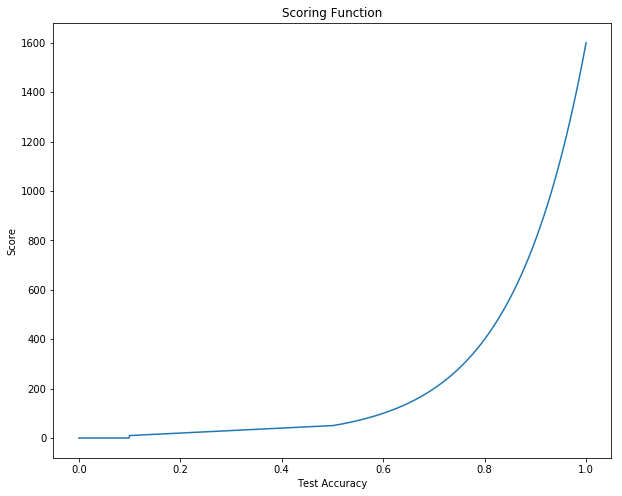

In [21]:
from dl4cv.data_utils import scoring_function

x = np.linspace(0, 1, num=1000)
plt.plot(x, scoring_function(x, lin_exp_boundary=0.5, doubling_rate=0.1))
plt.title('Scoring Function')
plt.xlabel('Test Accuracy')
plt.ylabel('Score')
plt.show()